# Assessing street network suitability for suistainable mobility with netapy

The netapy package is a pure-python implementation of the [NetAScore Toolbox](https://github.com/plus-mobilitylab/netascore), developed by the University of Salzburg. It is coded in such a way that it should make it easy to adapt or extend the default workflow, and to add other approaches to street network suitability assessment for sustainable transport modes as well.

This notebook will show an example of a basic netapy workflow: assessing the bikeability of all edges in a street network using the default NetAScore workflow.

Do note that the current version of netapy is still work in progress, and does not yet implement all parts of the NetAScore workflow. Currently it is lacking 1) derivation of some of the relevant attributes from OpenStreetMap data (as a placeholder they are assigned randomly instead), 2) the ability to parse overrides defintions of mode profiles, and 3) the ability to add non-OpenStreetMap attributes to the network (such as noise).

In [1]:
import netapy
import osmnx as ox

First, we load the street network to assess. When applying the default NetAScore workflow, we use the `NetascoreNetwork` class to represent such a network. To extent or adapt NetAScore you can write your own extension to that class, but we stick to the defaults here. There are several ways to initialize the street network, e.g. by providing a placename, a polygon or a bounding box. Under the hood, this all relies on the [osmnx package](https://osmnx.readthedocs.io/en/stable/) to load the relevant OpenStreetMap (OSM) features.

In [2]:
network = netapy.networks.NetascoreNetwork.from_place("Anif")

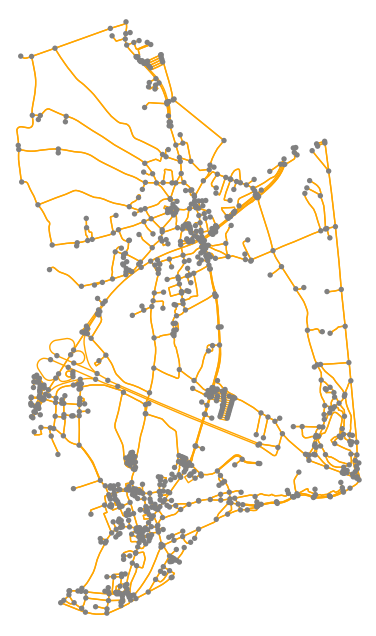

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
ox.plot_graph(network, bgcolor = "white", edge_color = "orange", node_color = "grey")

You can add additional OSM data to this network object, such as buildings or facilities. However, in a normal workflow you don't have to do this yourself, because when assessing the network all required additional data are fetched automatically whenever needed.

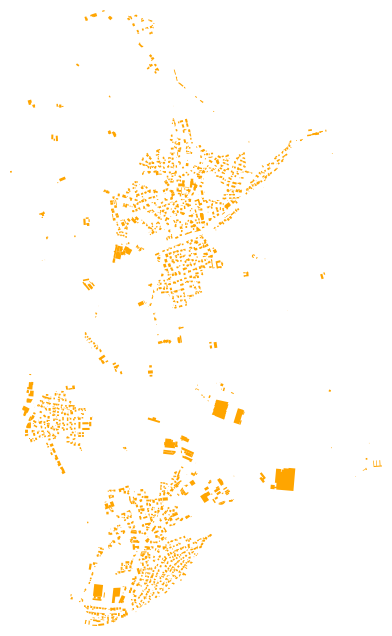

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
network.fetch_buildings()
ox.plot_footprints(network.buildings, bgcolor = "white", color = "orange")

Secondly, we initialize the assessor, which a worker object that is going to take care of assessing the network according to a certain mode profile. Here, we use the default bike profile of NetAScore. However, you can write you own custom NetAScore mode profile, or read it from a YAML file, using the `NetascoreProfile` class in the `profiles` module. Just as with the network, you can write your own extensions of the `NetascoreAssessor` and `NetascoreProfile` classes, to allow further customization of the workflow.

In [5]:
assessor = netapy.assessors.NetascoreAssessor(profile = "bike")

Now we are ready to assess the bikeability of the streets in our network. We can either adapt the network itself (setting `inplace = True`) or create a new network object (setting = `inplace = False`).

In [6]:
assessed = network.assess(assessor, inplace = False)

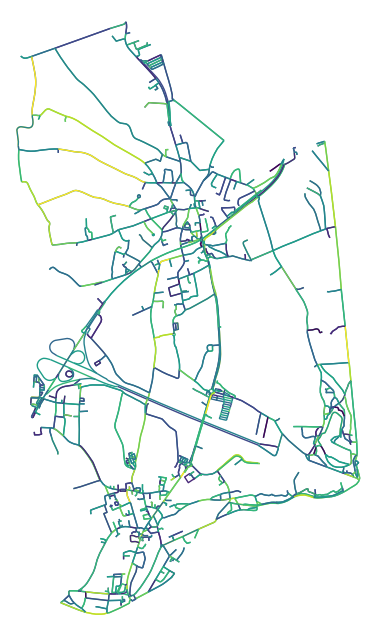

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
attr = f"index_{assessor.profile.name}:forward"
ec = ox.plot.get_edge_colors_by_attr(assessed, attr = attr, num_bins = 10)
ox.plot_graph(network, bgcolor = "white", node_size = 0, edge_color = ec)

We can see now that each edge in the assessed network contains the values of the relevant attributes (i.e. the utility attributes defining access as well as the indicator values), subindices (i.e. the normalized indicator values to the range [0,1], according to the indicator mapping in the mode profile) and composite indices (i.e. the final index in both travel directions, obtained by weighting the subindices according to the mode profile) of NetAScore.

In [8]:
list(assessed.edges(data = True))[0]

(35608985,
 4475973575,
 {'osmid': 244159321,
  'name': 'Berchtesgadener Straße',
  'highway': 'primary',
  'maxspeed': '50',
  'lanes': '4',
  'surface': 'asphalt',
  'oneway': False,
  'reversed': True,
  'length': 12.319,
  'bicycle_infrastructure:forward': 'no',
  'bicycle_infrastructure:backward': 'no',
  'index_bike:bicycle_infrastructure:forward': 0,
  'index_bike:bicycle_infrastructure:backward': 0,
  'designated_route:forward': 'regional',
  'designated_route:backward': 'regional',
  'index_bike:designated_route:forward': 0.85,
  'index_bike:designated_route:backward': 0.85,
  'road_category': 'path',
  'index_bike:road_category': 0,
  'max_speed:forward': 110,
  'max_speed:backward': 110,
  'index_bike:max_speed:forward': 0,
  'index_bike:max_speed:backward': 0,
  'parking:forward': 'yes',
  'parking:backward': 'yes',
  'index_bike:parking:forward': 0,
  'index_bike:parking:backward': 0,
  'pavement': 'soft',
  'index_bike:pavement': 0.4,
  'gradient:forward': 3,
  'gradient:

How all these additional columns are named is configured through the `naming_config` attribute of the assessor, which we can adapt to our wishes.

In [9]:
assessor.naming_config

{'index_prefix': 'index_',
 'index_suffix': '',
 'attribute_prefix': '',
 'attribute_suffix': '',
 'forward_prefix': '',
 'forward_suffix': ':forward',
 'backward_prefix': '',
 'backward_suffix': ':backward'}

In [10]:
assessor.naming_config["index_prefix"] = ""
assessor.naming_config["index_suffix"] = "ability"
assessor.naming_config["attribute_prefix"] = "attr:"

In [11]:
assessed = network.assess(assessor, inplace = False)

In [12]:
list(assessed.edges(data = True))[0]

(35608985,
 4475973575,
 {'osmid': 244159321,
  'name': 'Berchtesgadener Straße',
  'highway': 'primary',
  'maxspeed': '50',
  'lanes': '4',
  'surface': 'asphalt',
  'oneway': False,
  'reversed': True,
  'length': 12.319,
  'attr:bicycle_infrastructure:forward': 'no',
  'attr:bicycle_infrastructure:backward': 'no',
  'bikeability:bicycle_infrastructure:forward': 0,
  'bikeability:bicycle_infrastructure:backward': 0,
  'attr:designated_route:forward': 'international',
  'attr:designated_route:backward': 'international',
  'bikeability:designated_route:forward': 1,
  'bikeability:designated_route:backward': 1,
  'attr:road_category': 'residential',
  'bikeability:road_category': 0.8,
  'attr:max_speed:forward': 90,
  'attr:max_speed:backward': 90,
  'bikeability:max_speed:forward': 0.2,
  'bikeability:max_speed:backward': 0.2,
  'attr:parking:forward': 'no',
  'attr:parking:backward': 'no',
  'bikeability:parking:forward': 1,
  'bikeability:parking:backward': 1,
  'attr:pavement': 'so

It is important to notice that every time you assess a  network, by default all subindices and attributes of NetAScore are computed no matter if they already exist as a column in the edges table of the network. To read existing values of subindices and/or attributes, instead of re-computing them, change arguments as shown below. Be aware that this does not check if you are using a different assessor than the one that was used to generate the existing values.

In [13]:
assessed.assess(assessor, read_subs = True, read_attrs = True)
list(assessed.edges(data = True))[0]

(35608985,
 4475973575,
 {'osmid': 244159321,
  'name': 'Berchtesgadener Straße',
  'highway': 'primary',
  'maxspeed': '50',
  'lanes': '4',
  'surface': 'asphalt',
  'oneway': False,
  'reversed': True,
  'length': 12.319,
  'attr:bicycle_infrastructure:forward': 'no',
  'attr:bicycle_infrastructure:backward': 'no',
  'bikeability:bicycle_infrastructure:forward': 0,
  'bikeability:bicycle_infrastructure:backward': 0,
  'attr:designated_route:forward': 'international',
  'attr:designated_route:backward': 'international',
  'bikeability:designated_route:forward': 1,
  'bikeability:designated_route:backward': 1,
  'attr:road_category': 'residential',
  'bikeability:road_category': 0.8,
  'attr:max_speed:forward': 90,
  'attr:max_speed:backward': 90,
  'bikeability:max_speed:forward': 0.2,
  'bikeability:max_speed:backward': 0.2,
  'attr:parking:forward': 'no',
  'attr:parking:backward': 'no',
  'bikeability:parking:forward': 1,
  'bikeability:parking:backward': 1,
  'attr:pavement': 'so

Similarly, you can set that subindices and/or attributes of NetAScore should not be written to the network. In that case, only the final index is written.

In [14]:
assessed = network.assess(assessor, inplace = False, write_subs = False, write_attrs = False)

In [15]:
list(assessed.edges(data = True))[0]

(35608985,
 4475973575,
 {'osmid': 244159321,
  'name': 'Berchtesgadener Straße',
  'highway': 'primary',
  'maxspeed': '50',
  'lanes': '4',
  'surface': 'asphalt',
  'oneway': False,
  'reversed': True,
  'length': 12.319,
  'bikeability:forward': 0.54,
  'bikeability:backward': 0.54})